In [1]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from torch.optim.lr_scheduler import StepLR
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing
from torch.utils.tensorboard import SummaryWriter
from typing import List, Tuple, Optional
from torch.nn import Transformer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import sacrebleu
import torch
import math
import re
import os

import warnings
warnings.simplefilter("ignore")



In [2]:
#BPE TOKENIZER

class BPETokenizer:
    def __init__(self, sentence_list):

        self.tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        self.tokenizer.enable_truncation(max_length=15)
        self.tokenizer.enable_padding(length=15)
        self.tokenizer.pre_tokenizer = Whitespace()

        trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
        self.tokenizer.train_from_iterator(sentence_list, trainer)

    def __call__(self, sentence):

        return self.tokenizer.encode(sentence).ids


    def decode(self, token_list):

        return self.tokenizer.decode(token_list).split()

In [3]:
#DATASET

class MTDataset(Dataset):
    def __init__(self, tokenized_source_list, tokenized_target_list, dev):
        self.tokenized_source_list = tokenized_source_list
        self.tokenized_target_list = tokenized_target_list
        self.device = dev

    def __len__(self):
        return len(self.tokenized_source_list)

    def __getitem__(self, idx):
        source_ids, target_ids = torch.tensor(self.tokenized_source_list[idx]).to(self.device), \
                                 torch.tensor(self.tokenized_target_list[idx]).to(self.device)
        return source_ids, target_ids


In [4]:
#SPACETOKEN
class SpaceTokenizer:
    def __init__(self, sentence_list, pad_flag):
        self.pad_flag = pad_flag
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD", 4: " "}
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2, 'PAD': 3, " ": 4}
        self.n_words = len(self.word2index)
        self.max_sent_len = -1
        self.special_tokens_set = {'SOS', 'EOS', 'PAD'}

        for sent in sentence_list:
            token_list = sent.split()
            sent_words_amount = len(token_list)
            if sent_words_amount > self.max_sent_len:
                self.max_sent_len = sent_words_amount

            for token in token_list:
                if token not in self.word2index:
                    self.word2index[token] = self.n_words
                    self.word2count[token] = 1
                    self.index2word[self.n_words] = token
                    self.n_words += 1
                else:
                    self.word2count[token] += 1

        self.max_sent_len += 2

        print(f'Space tokenizer fitted - {len(self.word2index)} tokens')

    def pad_sent(self, token_ids_list):
        if len(token_ids_list) < self.max_sent_len:
            padded_token_ids_list = token_ids_list + [self.word2index['PAD']] * (self.max_sent_len - len(token_ids_list))
        else:
            padded_token_ids_list = token_ids_list[:self.max_sent_len - 1] + [self.word2index['EOS']]
        return padded_token_ids_list

    def __call__(self, sentence):
        tokenized_data = self.tokenize(sentence)
        if self.pad_flag:
            tokenized_data = self.pad_sent(tokenized_data)
        return tokenized_data

    def tokenize(self, sentence):
        tokenized_data = []
        tokenized_data.append(self.word2index['SOS'])
        for word in sentence.split():
            if word in self.word2index:
                tokenized_data.append(self.word2index[word])
            else:
                tokenized_data.append(self.word2index['UNK'])
        tokenized_data.append(self.word2index['EOS'])
        return tokenized_data

    def decode(self, token_list):
        predicted_tokens = []

        for token_id in token_list:
            predicted_token = self.index2word[token_id]
            predicted_tokens.append(predicted_token)
        filtered_tokens = list(filter(lambda x: x not in self.special_tokens_set, predicted_tokens))

        return filtered_tokens

In [5]:
#UTILS

class TextUtils:
    @staticmethod
    def normalize_text(s: str) -> str:

        s = s.lower()
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Zа-яйёьъА-Яй]+", r" ", s)
        s = s.strip()
        return s


    @staticmethod
    def read_langs_pairs_from_file(filename: str):

        with open(filename, mode="r", encoding="utf-8") as f:
            lines = f.read().strip().split("\n")

        lang_pairs = []
        for line in tqdm(lines, desc="Reading from file"):
            lang_pair = tuple(map(TextUtils.normalize_text, line.split("\t")[:2]))
            lang_pairs.append(lang_pair)

        return lang_pairs

def short_text_filter_function(x, max_length, prefix_filter=None):
    len_filter = lambda x: len(x[0].split(" ")) <= max_length and len(x[1].split(" ")) <= max_length
    if prefix_filter:
        prefix_filter_func = lambda x: x[0].startswith(prefix_filter)
    else:
        prefix_filter_func = lambda x: True
    return len_filter(x) and prefix_filter_func(x)


In [6]:
#ATTENTION

class Seq2seqAttention(torch.nn.Module):
    def __init__(self):
        super(Seq2seqAttention, self).__init__()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden[:, :, None]
        decoder_to_encoder_states = torch.matmul(encoder_states, decoder_hidden)
        sm_decoder_to_encoder_states = self.softmax(decoder_to_encoder_states)
        weighted_encoder_states = torch.matmul(sm_decoder_to_encoder_states.transpose(2,1), encoder_states).squeeze(dim=1)
        return weighted_encoder_states

In [7]:
#POSENC

class PositionalEncoding(torch.nn.Module):
    def __init__(self, emb_size, maxlen):

        super(PositionalEncoding, self).__init__()
        pass


    def forward(self, token_embedding):

        pass

In [8]:
#METRICS

def bleu_scorer(predicted: np.ndarray, actual: np.ndarray, target_tokenizer):

    batch_bleu = []
    predicted_sentences = []
    actual_sentences = []
    for a, b in zip(predicted, actual):

        words_predicted = target_tokenizer.decode(a)
        words_actual = target_tokenizer.decode(b)

        words_predicted = [' '.join(words_predicted)]
        words_actual = [' '.join(words_actual)]
     
        if words_predicted:
        
            bleu_score_ = sacrebleu.corpus_bleu(words_predicted, [words_actual])
            batch_bleu.append(bleu_score_.score)
        predicted_sentences.append(" ".join(words_predicted))
        actual_sentences.append(" ".join(words_actual))
    batch_bleu = np.mean(batch_bleu)
    return batch_bleu, actual_sentences, predicted_sentences

In [9]:

#POSENC SEQ2SEQ

class PositionalEncoding(nn.Module):
    def __init__(self, device, embedding_size, dropout, max_len=15):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2) * (-math.log(10000.0) / embedding_size))
        pos_embedding = torch.zeros(max_len, embedding_size)
        pos_embedding[:, 0::2] = torch.sin(position * div_term)
        pos_embedding[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pos_embedding', pos_embedding.unsqueeze(0).to(device))

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])


class Seq2SeqTransformer(nn.Module):
    def __init__(self, device, embedding_size, num_encoder_layers, dim_feedforward, src_voc_size, trg_voc_size,
                 target_tokenizer, source_tokenizer, lr_decay_step, lr=1e-4, lr_decay=0.1, dropout_rate=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.device = device
        self.special_tokens = {"pad": 0, "bos": 1, "eos": 2}

        self.src_emb = nn.Embedding(src_voc_size, embedding_size).to(device)
        self.trg_emb = nn.Embedding(trg_voc_size, embedding_size).to(device)
        self.positional_encoding = PositionalEncoding(device, embedding_size, dropout_rate)

        self.transformer = Transformer(d_model=embedding_size, num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=0, dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                       batch_first=True).encoder.to(device)

        self.vocab_projection_layer = nn.Linear(embedding_size, trg_voc_size).to(device)
        self.loss = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.Adam(self.transformer.parameters(), lr=lr)
        self.scheduler = StepLR(self.optimizer, step_size=lr_decay_step, gamma=lr_decay)

        self.target_tokenizer = target_tokenizer
        self.source_tokenizer = source_tokenizer

    def create_masks(self, src):
        src_mask = torch.zeros((src.shape[1], src.shape[1]), device=self.device).type(torch.bool)
        src_pad_mask = (src == self.special_tokens["pad"])
        return src_mask, src_pad_mask

    def forward(self, src):
        src_mask, src_pad_mask = self.create_masks(src)
        src_emb = self.positional_encoding(self.src_emb(src))
        out = self.transformer(src_emb, src_mask, src_pad_mask)
        logits = self.vocab_projection_layer(out)
        preds = torch.argmax(logits, dim=2)
        return preds, logits

    def training_step(self, batch):
        self.optimizer.zero_grad()
        _, logits = self.forward(batch[0])
        loss = self.loss(logits.view(-1, logits.shape[-1]), batch[1].view(-1))
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def validation_step(self, batch):
        with torch.no_grad():
            _, logits = self.forward(batch[0])
            loss = self.loss(logits.view(-1, logits.shape[-1]), batch[1].view(-1))
        return loss.item()

    def predict(self, sentences):
        src_tokenized = torch.tensor([self.source_tokenizer(s) for s in sentences]).to(self.device)
        preds = self.forward(src_tokenized)[0].cpu().detach().numpy()
        return [self.target_tokenizer.decode(i) for i in preds]

    def eval_bleu(self, predicted_ids_list, target_tensor):
        predicted = predicted_ids_list.detach().cpu().numpy()
        actuals = target_tensor.detach().cpu().numpy()
        return bleu_scorer(predicted, actuals, self.target_tokenizer)


In [10]:

#DATAMODULE

class DataManager:
    def __init__(self, config, device):
        super().__init__()
        self.config = config
        self.input_lang_n_words = None
        self.output_lang_n_words = None
        self.device = device

    def prepare_data(self):
        pairs = TextUtils.read_langs_pairs_from_file(filename=self.config["filename"])
        prefix_filter = self.config['prefix_filter']
        if prefix_filter:
            prefix_filter = tuple(prefix_filter)

        source_sentences,target_sentences = [], []
        unique_sources = set()
        for pair in pairs:
            source, target = pair[0], pair[1]
            if short_text_filter_function(pair, self.config['max_length'], prefix_filter) and source not in unique_sources:
                source_sentences.append(source)
                target_sentences.append(target)
                unique_sources.add(source)

        #source_sentences = source_sentences[:1000]
        #target_sentences = target_sentences[:1000]


        train_size = int(len(source_sentences)*self.config["train_size"])
        source_train_sentences, source_val_sentences = source_sentences[:train_size], source_sentences[train_size:]
        target_train_sentences, target_val_sentences = target_sentences[:train_size], target_sentences[train_size:]

        self.source_tokenizer = BPETokenizer(source_train_sentences)
        tokenized_source_train_sentences = [self.source_tokenizer(s) for s in source_train_sentences]
        tokenized_source_val_sentences = [self.source_tokenizer(s) for s in source_val_sentences]

        self.target_tokenizer = BPETokenizer(target_train_sentences)
        tokenized_target_train_sentences = [self.target_tokenizer(s) for s in target_train_sentences]
        tokenized_target_val_sentences = [self.target_tokenizer(s) for s in target_val_sentences]

        train_dataset = MTDataset(tokenized_source_list=tokenized_source_train_sentences,
                                  tokenized_target_list=tokenized_target_train_sentences, dev=self.device)

        val_dataset = MTDataset(tokenized_source_list=tokenized_source_val_sentences,
                                tokenized_target_list=tokenized_target_val_sentences, dev=self.device)

        train_dataloader = DataLoader(train_dataset, shuffle=True,
                                      batch_size=self.config["batch_size"])

        val_dataloader = DataLoader(val_dataset, shuffle=True,
                                    batch_size=self.config["batch_size"],drop_last=True )
        return train_dataloader, val_dataloader


In [11]:
#TRAINER

class Trainer:
    def __init__(self, model, model_config, logger, log_dir='C:/Users/fktif/Desktop/final_project/runs'):
        self.model = model
        self.epoch_num = model_config['epoch_num']
        self.logger = logger
        self.writer = SummaryWriter(log_dir)  
        self.logger.log(model_config)

    def train(self, train_dataloader, val_dataloader):
        try:
            for epoch in tqdm(range(self.epoch_num)):
                print(f"EPOCH - {epoch}")
                train_epoch_loss = 0
                self.model.train()
                for batch in train_dataloader:
                    train_loss = self.model.training_step(batch)
                    train_epoch_loss += train_loss
                train_epoch_loss = train_epoch_loss / len(train_dataloader)

                val_epoch_loss, val_epoch_bleu = 0, 0
                self.model.eval()
                for batch in val_dataloader:
                    val_loss = self.model.validation_step(batch)
                    val_epoch_loss += val_loss
                val_epoch_loss = val_epoch_loss / len(val_dataloader)

                input_tensor, target_tensor = batch
                predicted_samples, _ = self.model.forward(input_tensor)
                bleu_score, actual_sentences, predicted_sentences = self.model.eval_bleu(predicted_samples, target_tensor)
                print('Current BLEU: ', bleu_score)
                for a, b in zip(actual_sentences[:5], predicted_sentences[:5]):
                    print(f"{a} ---> {b}")
                print('------------------------------------')

                self.writer.add_scalar('Loss/train', train_epoch_loss, epoch)
                self.writer.add_scalar('Loss/val', val_epoch_loss, epoch)
                self.writer.add_scalar('BLEU/score', bleu_score, epoch)

                self.logger.log({
                    "val_loss": val_epoch_loss,
                    "train_loss": train_epoch_loss,
                    "bleu_score": bleu_score
                })

        except KeyboardInterrupt:
            pass

        print(f"Last {epoch} epoch train loss: ", train_epoch_loss)
        print(f"Last {epoch} epoch val loss: ", val_epoch_loss)
        print(f"Last {epoch} epoch val bleu: ", bleu_score)

        self.writer.close()

In [12]:
#LOGGER

class TXTLogger:
    def __init__(self, work_dir):
        self.save_dir = work_dir
        self.filename = "progress_log.txt"

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

        self.log_file_path = os.path.join(self.save_dir, self.filename)
        log_file = open(self.log_file_path, 'w')
        log_file.close()

    def log(self, data):
        with open(self.log_file_path, 'a') as f:
            f.write(f'{str(data)}\n')

In [13]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
data_manager = DataManager(
    config={
        "prefix_filter": [],
        "filename": 'rus.txt',
        "max_length": 13,
        "train_size": 0.8,
        "batch_size": 128
    },
    device=device
)
train_dataloader, val_dataloader = data_manager.prepare_data()

Reading from file: 100%|██████████| 399919/399919 [00:02<00:00, 170152.55it/s]


In [15]:
model = Seq2SeqTransformer(
    device=device,
    embedding_size=256,
    num_encoder_layers=8,
    dim_feedforward=4096,

    src_voc_size=len(data_manager.source_tokenizer.tokenizer.get_vocab()),
    trg_voc_size=len(data_manager.target_tokenizer.tokenizer.get_vocab()),
    source_tokenizer=data_manager.source_tokenizer,
    target_tokenizer=data_manager.target_tokenizer,

    lr_decay_step=5,
    lr=1e-4,
    lr_decay=1e-1
)


In [16]:
trainer_config = {
    'epoch_num': 15
}


logger = TXTLogger(work_dir="./")
trainer = Trainer(model, trainer_config, logger)

In [17]:
trainer.train(train_dataloader, val_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH - 0


  7%|▋         | 1/15 [02:03<28:46, 123.29s/it]

Current BLEU:  11.281875423719455
не думаю что я здесь уже бывал ---> не думаю что я я я
хочешь пойти в кино завтра вечером ---> ты бы бы в в
я весь день работал не покладая рук так что был очень уставшим ---> я все все что я я я
я знаю что некоторые люди ценят мою работу ---> я знаю что это на на
том пожертвовал жизнью чтобы спасти мэри ---> том его его мэри мэри мэри мэри
------------------------------------
EPOCH - 1


 13%|█▎        | 2/15 [04:05<26:36, 122.77s/it]

Current BLEU:  13.313576671436756
не думаю что у меня есть какие то дурные привычки ---> не думаю что у у меня
по правде говоря я её недолюбли ваю ---> скажи скажи я я я не
они оставались со мной в комнате всю ночь ---> они не со меня в в
том счёл книгу которую ему дала мэри довольно скучной ---> том нашёл как мэри мэри мэри мэри
с каждым днём холодает ---> день день день день день
------------------------------------
EPOCH - 2


 20%|██        | 3/15 [06:05<24:16, 121.34s/it]

Current BLEU:  12.413857015972445
что ты да ришь тому на день рождения ---> что ты ты тому тома
том при бер ёг последнюю пу лю для себя ---> том в на на
к тому времени как мы туда доберёмся том будет спать ---> том будет будет время
не думаю что кто то мог остановить тома ---> не думаю что кто кто нибудь тома тома
если мы сор гани зу емся мы сможем кое что сделать ---> если мы мы что что можем то то
------------------------------------
EPOCH - 3


 27%|██▋       | 4/15 [08:03<22:03, 120.28s/it]

Current BLEU:  14.309176081366397
я поклялся что никогда больше не буду с нею разговаривать ---> я не что никогда никогда не с с
я и не знал что том родился в австралии ---> я даже не знал что том в
как тебе удалось уговорить тома сделать это ---> как тебе должен тому это это сделать
это лучший фильм из всех что я когда либо видел ---> это всё как я я я
не думаю что это только я заметил ---> не думаю что я я я
------------------------------------
EPOCH - 4


 33%|███▎      | 5/15 [10:06<20:10, 121.01s/it]

Current BLEU:  17.049600414079862
я не уйду пока ты не скажешь мне что происходит ---> я не не что что что мне
я не думаю что заслужил наказание которое получил ---> не думаю что я я
ни том ни мэри не говорили об этом с джоном ---> ни том ни мэри не об этом этом этом
работа должна быть закончена к понедельнику ---> эта работа должен быть в в
я думал что ты весь день проспишь ---> я думал ты день день день день
------------------------------------
EPOCH - 5


 40%|████      | 6/15 [12:08<18:11, 121.30s/it]

Current BLEU:  18.717730186468245
я даже пытался написать песню о том что произошло ---> я даже пытался о о о том
никто не может ла дить с таким человеком ---> никто не может может с не
не понимаю зачем тому это делать ---> не не почему почему тому это делать
я встал раньше обычного чтобы успеть на первый поезд ---> я встал чем чем чем
помни что все мы в одной лодке ---> помню что мы все в в
------------------------------------
EPOCH - 6


 47%|████▋     | 7/15 [14:09<16:10, 121.26s/it]

Current BLEU:  19.264864789703893
не думаю что у меня есть на это время ---> не думаю что у меня меня это
на вечеринке том и мэри обменялись телефонами ---> том и мэри и на на вечеринку
спасибо тебе за помощь в написа нии моего резюме ---> спасибо что что мне мне
не думаю что том это уже сделал ---> не думаю что том это это сделал
с моей стороны было беспечно стью забыть запереть дверь ---> это было что меня о дверь
------------------------------------
EPOCH - 7


 53%|█████▎    | 8/15 [16:09<14:06, 120.93s/it]

Current BLEU:  19.37272434151981
я совершенно случайно встретил в аэропорту старого друга ---> довольно на шанс я я с в
темнеет включи свет пожалуйста ---> на нет пожалуйста пожалуйста
том позвал мэри но ответа не было ---> том позвонил мэри и там не
я думал ты хочешь выучить французский ---> я думал ты хотел изучать французский
мне трудно ответить на этот вопрос ---> мне трудно мне вопрос вопрос
------------------------------------
EPOCH - 8


 60%|██████    | 9/15 [18:09<12:04, 120.76s/it]

Current BLEU:  18.095111038677665
ваша ску дная память это след ствие плохих слу хо вых привычек ---> у дети тебя за за чтобы
том открыл переднюю дверь и вошёл ---> том открыл дверь дверь и
они учились здесь шесть месяцев ---> они здесь здесь в шесть
том был проница тельным бизне сменом за работа вшим много денег ---> том был много денег денег много денег
ты мне никогда не рассказывал о том что случилось ---> ты никогда не не мне о что что
------------------------------------
EPOCH - 9


 67%|██████▋   | 10/15 [20:13<10:07, 121.49s/it]

Current BLEU:  19.862582568719418
интересно почему люди всегда хотят знать правду ---> интересно почему почему всегда знать знать правду правду
ты выглядишь немного больным ---> ты выглядишь немного по по
у тома есть фотография мэри на стене в спальне ---> у тома есть мэри в в мэри
цвета американ ского флага красный белый и синий ---> спать из и и и и
ты должен сделать доклад к понедельнику ---> ты должно быть до до в
------------------------------------
EPOCH - 10


 73%|███████▎  | 11/15 [22:14<08:06, 121.51s/it]

Current BLEU:  17.8200199398306
хочешь мы отвезём тебя обратно домой ---> хочешь чтобы чтобы мы тебя тебя
родители должны следить за благо получи ем своих детей ---> родители должно за за за
я бы удивился если бы том этого не сделал ---> я бы удивился если бы том этого делал делал
в мире много плохих людей ---> в много много людей
люди всегда спрашивают меня почему я делаю то что я делаю ---> люди всегда спроси меня почему я я что я я
------------------------------------
EPOCH - 11


 80%|████████  | 12/15 [24:16<06:04, 121.51s/it]

Current BLEU:  21.234956900180347
вечером у нас будет несколько гостей ---> в вечер у нас
я думаю что том не очень хороший певец ---> думаю думаю том не очень очень
в жизни есть более важные вещи ---> в есть есть есть
река разли лась из за силь ных дождей ---> река река от за дождь
обычно у меня плотный завтрак и лёгкий обед ---> обычно обычно ем большой и и
------------------------------------
EPOCH - 12


 87%|████████▋ | 13/15 [26:19<04:04, 122.14s/it]

Current BLEU:  21.067114916722566
это самый большой храм из тех что я когда либо видел ---> это маджонг в на я когда я я
никто не пытается заставить тебя что то делать ---> никто не не ничего ничего что сделать
я хочу чтобы ты остался в бостоне до моего дня рождения ---> я хочу чтобы ты остался в в до рождения рождения
вы без сомнения слышали о нашей компании ---> ты не не в слышал нашей
каждый раз когда автобус при тор ма живает том просыпается ---> в раз автобус на тома тома тома тома
------------------------------------
EPOCH - 13


 93%|█████████▎| 14/15 [28:21<02:01, 121.92s/it]

Current BLEU:  21.786149981346618
ребёнок вскоре заснул в колыбели ---> ребёнок том зите в
смерть тома была несчастным случаем вы уверены ---> смерть тома была был вы
климат здесь холоднее чем я предполагал ---> здесь здесь здесь чем я я ожидал ожидал
ты хочешь чтобы я помог тебе с приготовлением пищи ---> ты чтобы чтобы я помог с с
мэри лин монро умерла когда ей было лет ---> рави бога выводу брать умер когда
------------------------------------
EPOCH - 14


100%|██████████| 15/15 [30:22<00:00, 121.51s/it]

Current BLEU:  21.41007293142588
том не знал плакать ему или смеяться ---> том не знал что он флиртует
тебе необязательно отвечать на все вопросы ---> ты не должен отвечать на вопросы
ты не знал что том видел как ты это делал ---> ты не знал что том видел как это это это
он осуществил свою меч ту стать художником ---> он понял свои мечта художник
том ведёт себя так будто ничего не случилось ---> том ведёт себя так так ничего не случилось
------------------------------------
Last 14 epoch train loss:  1.153939488351097
Last 14 epoch val loss:  3.2071023713974727
Last 14 epoch val bleu:  21.41007293142588


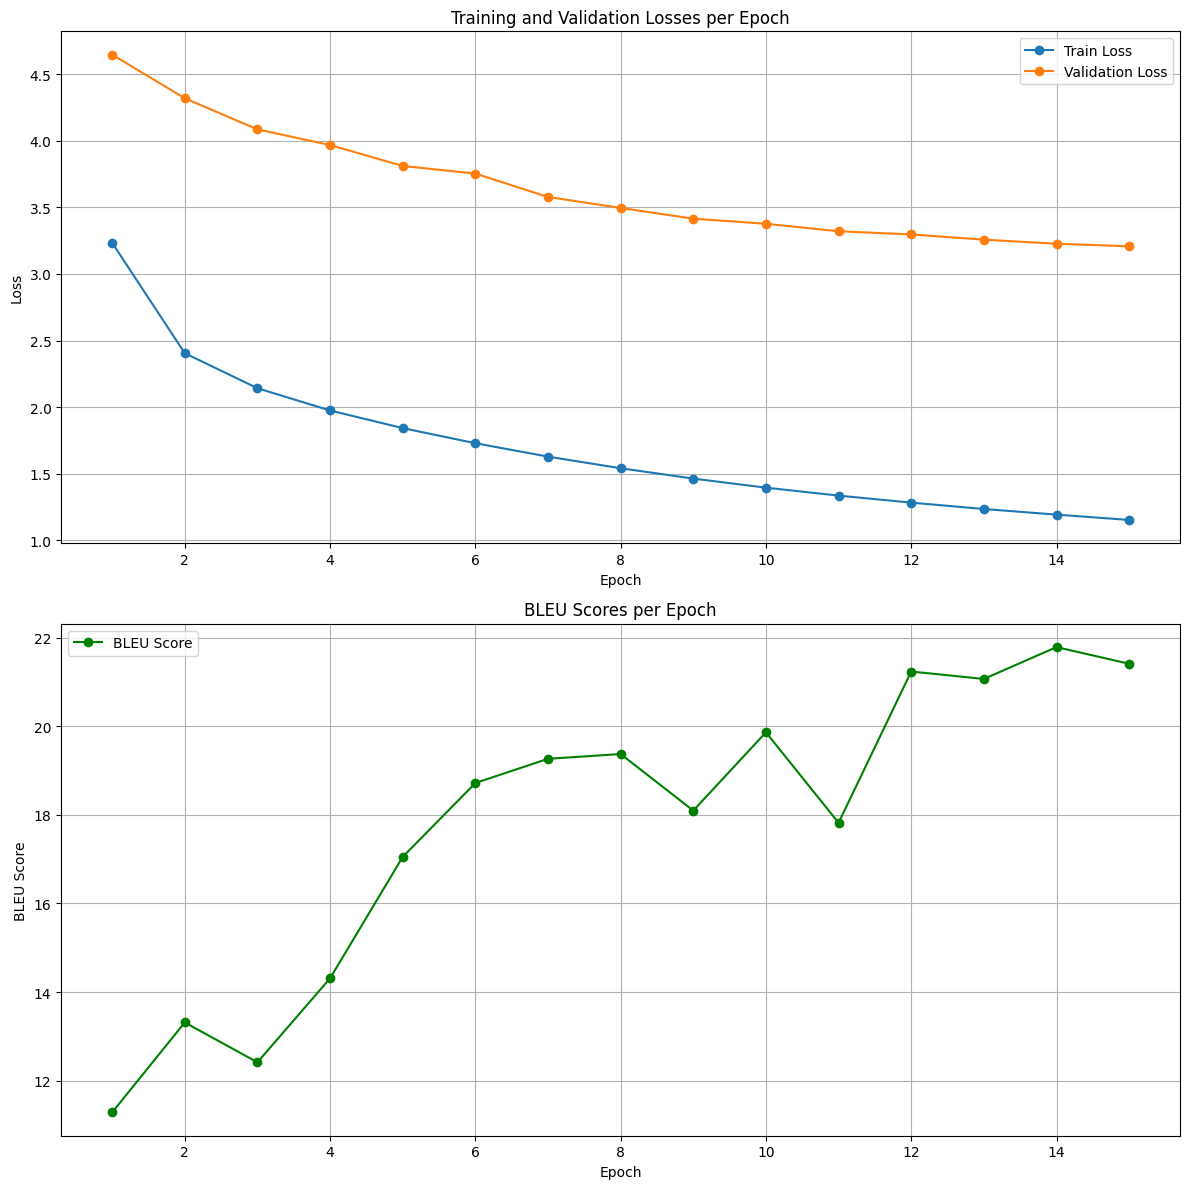

In [18]:

import matplotlib.pyplot as plt

file_path = 'progress_log.txt'

epoch_nums = []
val_losses = []
train_losses = []
bleu_scores = []

with open(file_path, 'r') as file:
    for line in file:
        if 'epoch_num' not in line:
            data = eval(line.strip().replace('nan', '0'))
            val_losses.append(data['val_loss'])
            train_losses.append(data['train_loss'])
            bleu_scores.append(data['bleu_score'])
            epoch_nums.append(len(epoch_nums) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(epoch_nums, train_losses, label='Train Loss', marker='o')
ax1.plot(epoch_nums, val_losses, label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Losses per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epoch_nums, bleu_scores, label='BLEU Score', color='green', marker='o')
ax2.set_title('BLEU Scores per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [42]:
sentences_to_translate = [
    "you work hard",
    "tom was sick",
    "summer is here",
    "tom will win",
    "i wonder where she lives",
    "you will be there again soon",
    "i rarely make a mistake",
    "i knew all about that",
    "i plan on going there",
    "we are going to swim"
]



def translate_sentences(model, sentences):
    model.eval()
    predicted_sentences = model.predict(sentences)

    return [" ".join(sentence) for sentence in predicted_sentences]

translated_sentences = translate_sentences(model, sentences_to_translate)
for translated in translated_sentences:
    print(translated)




ты много работаешь
том был болен
лето лето
том выиграет
интересно где она живёт
ты скоро там там будешь
я редко делаю ошибку
я всё об этом знал
я планирую туда туда
мы будем
